In [1]:
!pip install -q optuna pykalman openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pykalman import KalmanFilter
from scipy.signal import savgol_filter
import warnings
import urllib.request
import os
from google.colab import files

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the Data

In [3]:
# Upload the data
uploaded = files.upload()

Saving COT_JPY.xlsx to COT_JPY.xlsx


In [4]:
def load_single_column_excel(filepath):
    """
    Load a single-column Excel file and return the data as a pandas DataFrame with synthetic daily dates.

    Parameters:
    - filepath: str, path to the Excel file.

    Returns:
    - df_processed: pandas DataFrame with a generated daily date index and a single data column.
    """
    # Read the Excel file
    df = pd.read_excel(filepath)

    # Check the number of columns
    if df.shape[1] != 1:
        raise ValueError(f"Expected 1 column, but found {df.shape[1]} columns.")

    # Extract the data
    data = df.iloc[:, 0]

    # Generate synthetic daily dates starting from 2020-01-01
    start_date = '2020-01-01'
    periods = len(data)
    freq = 'D'  # Daily frequency

    # Generate date range
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)

    # Create a DataFrame with dates as the index
    df_processed = pd.DataFrame({'COT_JPY_Value': data.values}, index=dates)

    return df_processed

In [5]:
# Identify the uploaded file name
uploaded_files = list(uploaded.keys())
if len(uploaded_files) == 0:
    raise ValueError("No file uploaded. Please upload the 'COT_JPY.xlsx' file.")

filepath = '/content/' + uploaded_files[0]
print(filepath)

/content/COT_JPY.xlsx


In [6]:
# Load the data
df = load_single_column_excel(filepath)

# Verify the loaded data
print(f"Loaded data has {df.shape[0]} data points.")
print("First 5 rows of the DataFrame:")
display(df.head())

Loaded data has 448 data points.
First 5 rows of the DataFrame:


,COT_JPY_Value
2020-01-01,-79.1
2020-01-02,-69.6
2020-01-03,-60.9
2020-01-04,-59.3
2020-01-05,-64.1


In [7]:
def plot_time_series(df, title='Time Series Data', xlabel='Date', ylabel='Value',
                    figsize=(14, 7), color='blue', linestyle='-', marker=None,
                    show_moving_average=False, window=30):
    """
    Plots the time series data.

    Parameters:
    - df: pandas DataFrame with a date index and a single data column.
    - title: str, the title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - figsize: tuple, the size of the figure.
    - color: str, color of the plot line.
    - linestyle: str, style of the plot line.
    - marker: str or None, marker style for data points.
    - show_moving_average: bool, whether to show a moving average line.
    - window: int, the window size for the moving average.
    """
    plt.figure(figsize=figsize)

    plt.plot(df.index, df.iloc[:, 0], label='Data', color=color, linestyle=linestyle, marker=marker)

    if show_moving_average:
        moving_avg = df.iloc[:, 0].rolling(window=window).mean()
        plt.plot(df.index, moving_avg, label=f'Moving Average ({window})', color='red', linestyle='--')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

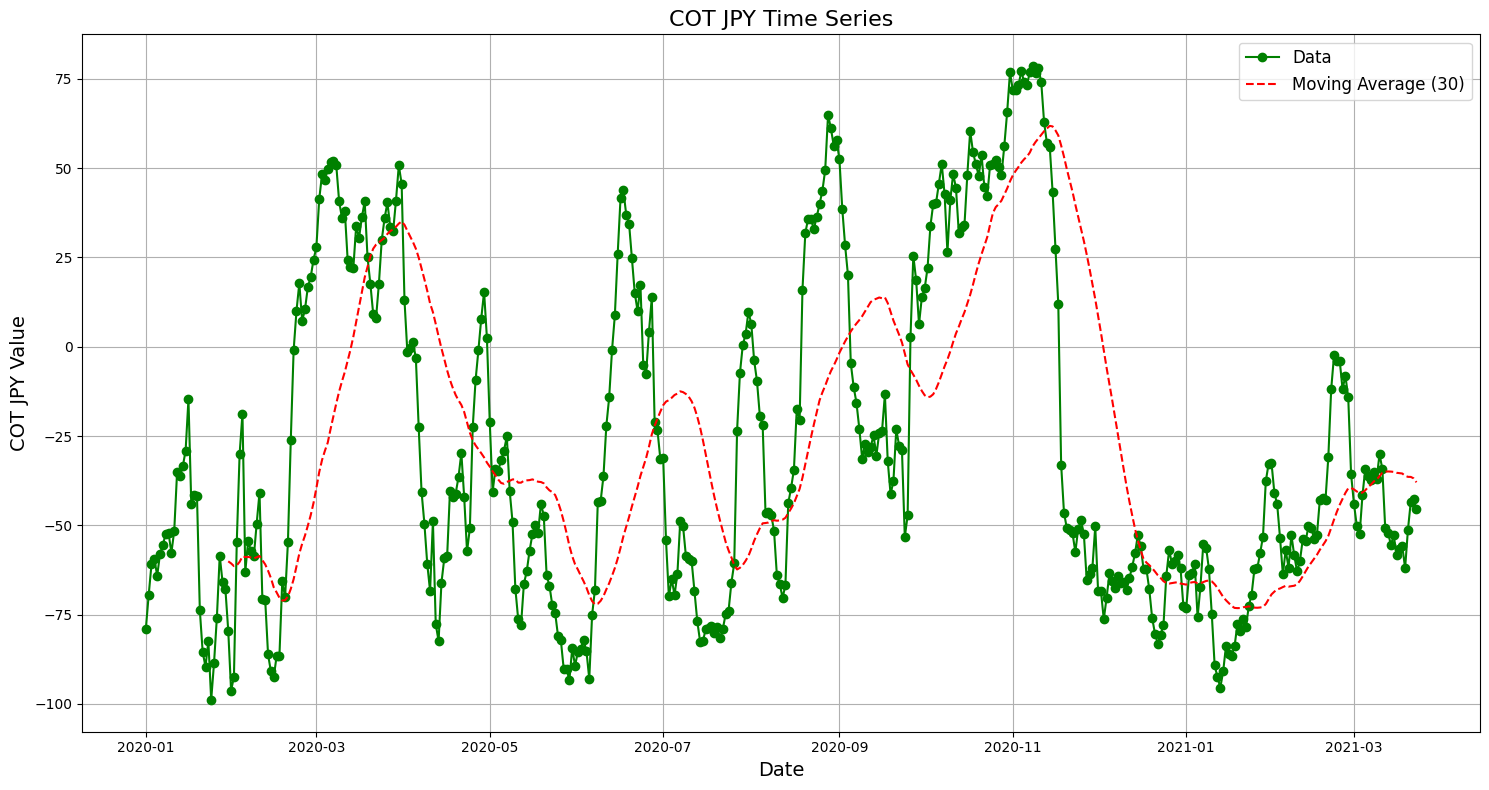

In [8]:
# Plot the raw time series
plot_time_series(
    df=df,
    title='COT JPY Time Series',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8),
    color='green',
    linestyle='-',
    marker='o',
    show_moving_average=True,
    window=30
)

# Preprocess the Data

In [9]:
def difference_data(df, order=1):
    """
    Applies differencing to make the time series stationary.

    Parameters:
    - df: pandas DataFrame with a date index and a single data column.
    - order: int, order of differencing.

    Returns:
    - data_diff: pandas Series, differenced data.
    """
    data = df.iloc[:, 0]
    data_diff = data.diff(periods=order).dropna()
    print(f"Differenced data length (order {order}): {len(data_diff)}")
    return data_diff.reset_index(drop=True)

In [10]:
def create_lag_features(data_diff, num_lags):
    """
    Creates lag features from the differenced data.

    Parameters:
    - data_diff: pandas Series, differenced data.
    - num_lags: int, number of lag features.

    Returns:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    """
    X, y = [], []
    for i in range(len(data_diff) - num_lags):
        X.append(data_diff[i:i + num_lags].values)
        y.append(data_diff[i + num_lags])

    X = np.array(X)
    y = np.array(y)
    print(f"Total samples after creating lag features: {X.shape[0]}")
    return X, y

In [11]:
def split_data(X, y, train_split):
    """
    Splits the data into training and testing sets based on the split ratio.

    Parameters:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    - train_split: float, proportion of data to use for training (e.g., 0.80 for 80%).

    Returns:
    - X_train: numpy array, training features.
    - y_train: numpy array, training targets.
    - X_test: numpy array, testing features.
    - y_test: numpy array, testing targets.
    """
    split_idx = int(len(X) * train_split)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    return X_train, y_train, X_test, y_test

In [12]:
def preprocess_time_series(df, num_lags, train_split):
    """
    Orchestrates the preprocessing steps: differencing, creating lag features, and splitting data.

    Parameters:
    - df: pandas DataFrame with a date index and a single data column.
    - num_lags: int, number of lag features.
    - train_split: float, proportion of data to use for training.

    Returns:
    - X_train, y_train, X_test, y_test: numpy arrays for training and testing.
    - dates_train, dates_test: pandas Series for training and testing dates.
    """
    # Step 1: Differencing
    data_diff = difference_data(df, order=1)

    # Step 2: Creating lag features
    X, y = create_lag_features(data_diff, num_lags)

    # Step 3: Splitting data
    X_train, y_train, X_test, y_test = split_data(X, y, train_split)

    # Extract corresponding dates for y_train and y_test
    # Align dates: the target corresponds to the date after the lagged features
    total_lags = num_lags
    dates = df.index[1:].to_series().reset_index(drop=True)  # Dates after differencing
    dates = dates[total_lags:len(y)+total_lags]  # Adjust dates to match y

    split_idx = int(len(y) * train_split)
    dates_train = dates[:split_idx].reset_index(drop=True)
    dates_test = dates[split_idx:].reset_index(drop=True)

    print(f"Training dates range from {dates_train.iloc[0]} to {dates_train.iloc[-1]}")
    print(f"Testing dates range from {dates_test.iloc[0]} to {dates_test.iloc[-1]}")

    return X_train, y_train, X_test, y_test, dates_train, dates_test

In [13]:
# Parameters
NUM_LAGS = 60  # Number of lag features
TRAIN_SPLIT = 0.80  # 80% for training

# Preprocess the data
X_train, y_train, X_test, y_test, dates_train, dates_test = preprocess_time_series(
    df=df,
    num_lags=NUM_LAGS,
    train_split=TRAIN_SPLIT
)

Differenced data length (order 1): 447
Total samples after creating lag features: 387
Training samples: 309
Testing samples: 78
Training dates range from 2020-03-02 00:00:00 to 2021-01-04 00:00:00
Testing dates range from 2021-01-05 00:00:00 to 2021-03-23 00:00:00


In [14]:
# Verify the shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (309, 60)
y_train shape: (309,)
X_test shape: (78, 60)
y_test shape: (78,)


In [15]:
def plot_train_test_split_full_data(df, dates_train, y_train, dates_test, y_test, title='Training and Testing Split',
                                    xlabel='Date', ylabel='Differenced COT JPY Value',
                                    figsize=(15, 8), train_color='blue', test_color='orange',
                                    alpha=0.3):
    """
    Plots the training and testing data on the differenced time series.

    Parameters:
    - df: pandas DataFrame with a date index and a single data column.
    - dates_train: pandas Series, dates corresponding to y_train.
    - y_train: numpy array, training targets.
    - dates_test: pandas Series, dates corresponding to y_test.
    - y_test: numpy array, testing targets.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - figsize: tuple, size of the plot.
    - train_color: str, color for the training split.
    - test_color: str, color for the testing split.
    - alpha: float, transparency for the shaded areas.
    """
    plt.figure(figsize=figsize)

    # Plot the entire differenced data
    data_diff = df.iloc[:, 0].diff().dropna().reset_index(drop=True)
    plt.plot(df.index[1:], data_diff, label='Differenced Data', color='gray', alpha=0.5)

    # Plot training data
    plt.plot(dates_train, y_train, label='Training Data', color=train_color)

    # Plot testing data
    plt.plot(dates_test, y_test, label='Testing Data', color=test_color)

    # Highlight the split point
    split_date = dates_train.iloc[-1]
    plt.axvline(x=split_date, color='black', linestyle='--', label='Train/Test Split')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Improve x-axis date formatting
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

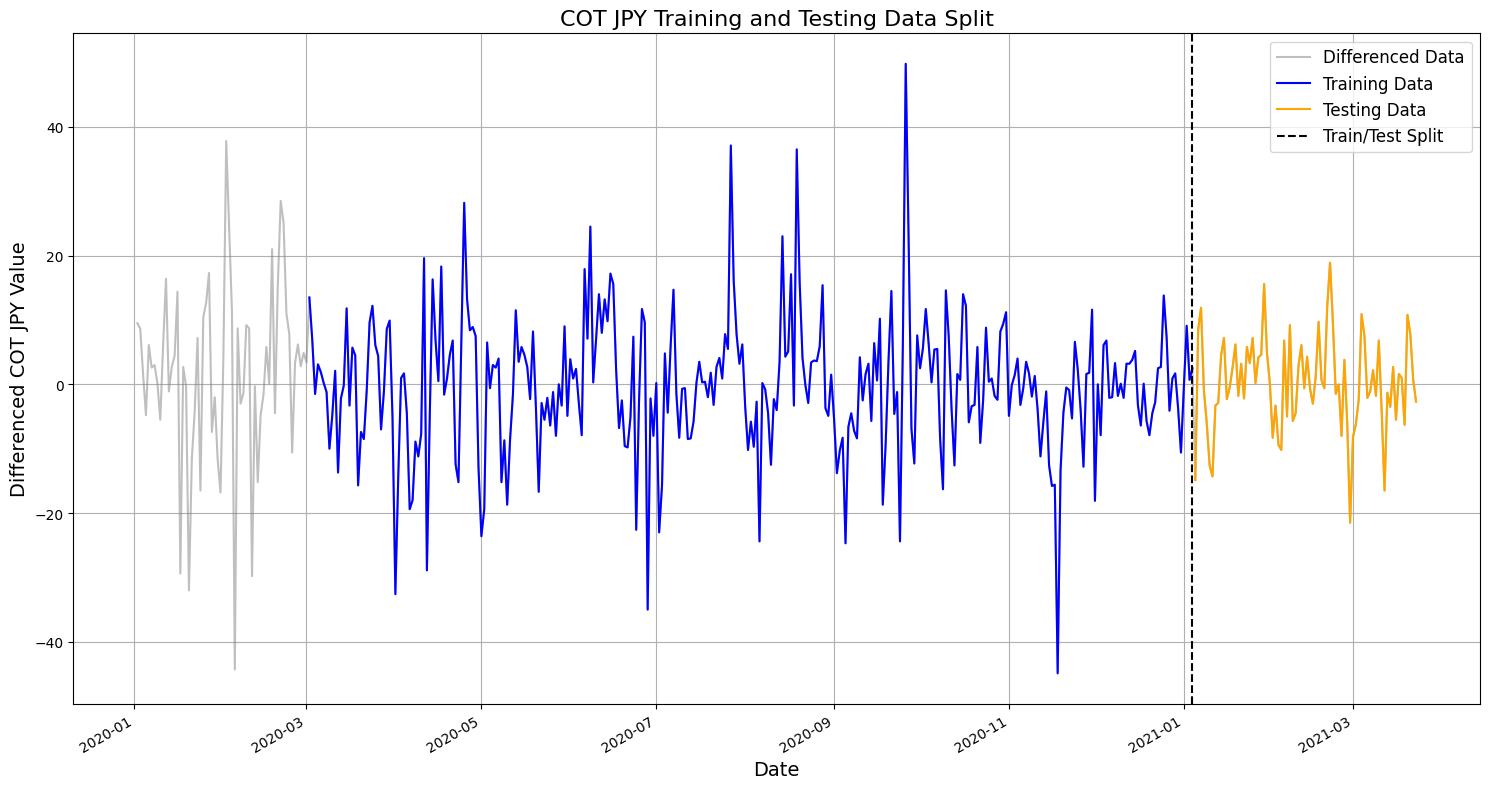

In [16]:
# Visualize the splits
plot_train_test_split_full_data(
    df=df,
    dates_train=dates_train,
    y_train=y_train,
    dates_test=dates_test,
    y_test=y_test,
    title='COT JPY Training and Testing Data Split',
    xlabel='Date',
    ylabel='Differenced COT JPY Value',
    figsize=(15, 8),
    train_color='blue',
    test_color='orange',
    alpha=0.3
)

# XGBoost Model

In [17]:
# Initialize the XGBoost Regressor
model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [18]:
# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

In [19]:
# Reconstruct predictions to original scale

# 1. Identify the last original value in the training set
last_train_index = NUM_LAGS + len(X_train) - 1
y_original_train_last = df['COT_JPY_Value'].iloc[last_train_index]
print(f"Last original value in training set: {y_original_train_last}")

# 2. Reconstruct y_pred_original by cumulatively summing y_pred and adding to last_train_y_original
y_pred_original = y_original_train_last + np.cumsum(y_pred)
print("Reconstructed predicted values on original scale:")
print(y_pred_original)

Last original value in training set: -63.3
Reconstructed predicted values on original scale:
[-64.33537  -64.31428  -59.201473 -56.532547 -56.168556 -60.139687
 -63.781292 -64.83302  -65.01852  -62.39597  -62.333828 -60.433952
 -52.174664 -50.31189  -59.462357 -65.38132  -65.53465  -64.39522
 -64.09384  -63.783047 -56.70036  -52.333157 -51.11778  -45.80966
 -42.78399  -41.27973  -40.10712  -39.613773 -48.551514 -49.393227
 -54.108986 -57.09231  -53.402775 -58.23927  -59.859234 -70.082664
 -77.79809  -76.95877  -76.214165 -78.29167  -75.58407  -74.52588
 -74.76539  -71.32183  -69.001396 -65.38009  -60.433308 -51.31098
 -44.400166 -44.345352 -43.084095 -41.180717 -39.677025 -37.319164
 -43.721176 -49.489708 -54.66056  -61.12908  -65.181305 -64.71445
 -65.65776  -66.744965 -68.20233  -70.01414  -72.94044  -73.473434
 -77.948235 -76.82948  -72.738945 -75.58509  -75.83009  -77.997116
 -77.980865 -74.56875  -75.89932  -72.16446  -79.63126  -78.41537 ]


In [20]:
# Reconstruct actual test values on original scale

# Extract the actual original values corresponding to the test set
start_test_index = last_train_index + 1
end_test_index = last_train_index + len(y_test) + 1  # +1 because iloc is exclusive at the end

y_test_original = df['COT_JPY_Value'].iloc[start_test_index:end_test_index].values
print("Actual test values on original scale:")
print(y_test_original)

Actual test values on original scale:
[-60.8 -75.7 -67.2 -55.3 -56.2 -62.3 -74.9 -89.2 -92.5 -95.4 -90.9 -83.7
 -86.  -86.5 -83.9 -77.7 -79.5 -76.3 -78.5 -72.7 -69.4 -62.2 -62.  -57.8
 -53.2 -37.6 -32.7 -32.5 -40.8 -44.1 -53.5 -63.7 -56.9 -61.9 -52.7 -58.4
 -62.9 -60.  -53.9 -54.5 -50.2 -50.8 -53.8 -52.6 -42.9 -42.2 -42.8 -30.8
 -11.9  -2.4  -3.9  -3.9 -11.9  -8.1 -14.2 -35.7 -43.9 -50.1 -52.5 -41.6
 -34.1 -36.2 -37.3 -35.1 -36.9 -30.1 -34.2 -50.7 -52.  -55.5 -52.8 -58.3
 -56.7 -55.7 -62.  -51.2 -43.4 -42.7]


In [21]:
# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Model Performance on Test Set:
Mean Squared Error (MSE): 507.6251
Root Mean Squared Error (RMSE): 22.5305
Mean Absolute Error (MAE): 19.5018


In [22]:
def plot_actual_vs_predicted_original(dates_test, y_test_original, y_pred_original,
                                      title='Actual vs. Predicted COT JPY Values',
                                      xlabel='Date', ylabel='COT JPY Value',
                                      figsize=(15, 8), actual_color='blue', predicted_color='red'):
    """
    Plots the actual versus predicted values on the original scale.

    Parameters:
    - dates_test: pandas Series, dates corresponding to the test set.
    - y_test_original: numpy array, actual target values on original scale.
    - y_pred_original: numpy array, predicted target values on original scale.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - figsize: tuple, size of the plot.
    - actual_color: str, color for the actual values.
    - predicted_color: str, color for the predicted values.
    """
    plt.figure(figsize=figsize)

    plt.plot(dates_test, y_test_original, label='Actual', color=actual_color)
    plt.plot(dates_test, y_pred_original, label='Predicted', color=predicted_color, linestyle='--')

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Improve x-axis date formatting
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

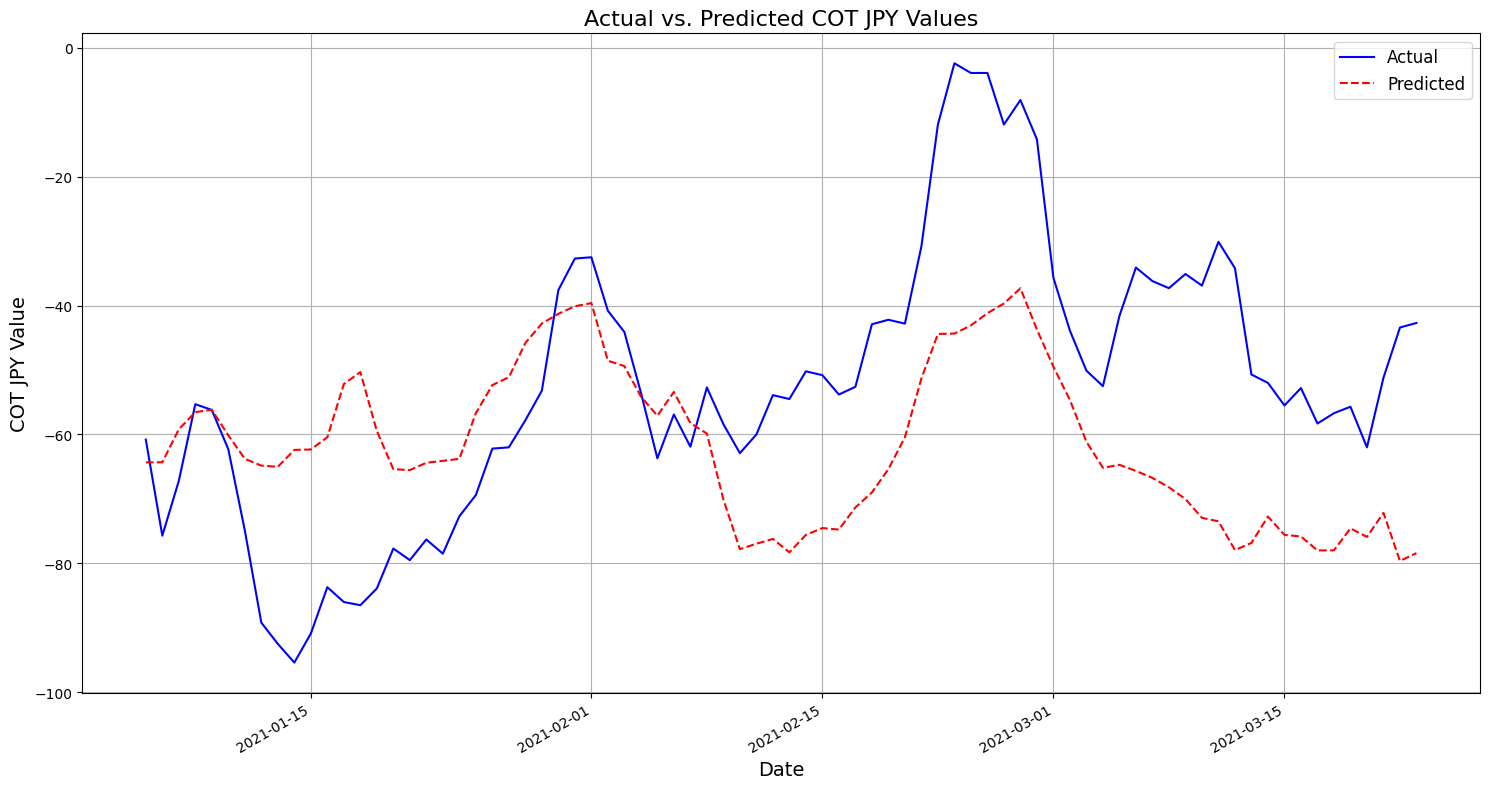

In [23]:
# Plot actual vs. predicted on original scale
plot_actual_vs_predicted_original(
    dates_test=dates_test,
    y_test_original=y_test_original,
    y_pred_original=y_pred_original,
    title='Actual vs. Predicted COT JPY Values',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8),
    actual_color='blue',
    predicted_color='red'
)

# Model Tuning

## RandomizedSearchCV

In [24]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

In [25]:
# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [26]:
# Initialize the XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

In [27]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [28]:
# Fit RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=No...
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_alpha': [0, 0.01, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2, 3],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [29]:
# Retrieve the best parameters and best score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (RandomizedSearchCV): {best_params_random}")
print(f"Best CV Score (Negative MSE): {best_score_random:.4f}")

Best Parameters (RandomizedSearchCV): {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}
Best CV Score (Negative MSE): -104.7810


In [30]:
# Retrieve the best estimator
best_model_random = random_search.best_estimator_

In [31]:
# Predict on the testing data
y_pred_random = best_model_random.predict(X_test)

In [32]:
def reconstruct_original_scale_iterative(y_original_last, y_pred_diff):
    """
    Reconstructs the original scale predictions from differenced predictions iteratively.

    Parameters:
    - y_original_last: float, the last known original value from the training set.
    - y_pred_diff: numpy array, predicted differenced values.

    Returns:
    - y_pred_original: numpy array, reconstructed predictions on original scale.
    """
    y_pred_original = []
    current = y_original_last
    for diff in y_pred_diff:
        current += diff
        y_pred_original.append(current)
    return np.array(y_pred_original)

In [33]:
# Reconstruct predictions to original scale using iterative method
y_pred_random_original = reconstruct_original_scale_iterative(y_original_train_last, y_pred_random)
print("Reconstructed predicted values on original scale (RandomizedSearchCV):")
print(y_pred_random_original)

Reconstructed predicted values on original scale (RandomizedSearchCV):
[-61.07043939 -62.59952347 -59.18443935 -54.15554206 -56.09946601
 -57.62355642 -58.94453173 -60.46937864 -59.36761467 -59.39535166
 -61.66192629 -61.41323763 -60.78523761 -60.15029395 -67.82623875
 -69.39947271 -67.09253454 -62.79855108 -62.92272458 -63.51244381
 -60.60883597 -53.11009005 -53.19880973 -49.84424888 -46.59756981
 -46.48164899 -46.59960531 -45.35624908 -48.59611963 -49.17277663
 -53.76021998 -53.75041744 -52.72243961 -55.85768231 -58.53399071
 -63.03034386 -68.06719717 -67.7077038  -68.00397596 -69.67292079
 -67.2774783  -67.55229956 -67.2115975  -64.35607844 -65.23494023
 -64.11480671 -61.71728855 -53.26275116 -48.83473307 -46.79127151
 -46.45404488 -42.27341562 -39.32947498 -38.22487586 -43.29194301
 -50.99812072 -56.82482046 -63.61892551 -69.11092704 -67.74395555
 -72.94255537 -72.95820495 -72.81504238 -74.71001888 -75.00196723
 -76.04289237 -78.29568759 -76.10701815 -72.06260363 -73.30443219
 -72.

In [34]:
# Compute evaluation metrics
mse_random = mean_squared_error(y_test_original, y_pred_random_original)
rmse_random = np.sqrt(mse_random)
mae_random = mean_absolute_error(y_test_original, y_pred_random_original)

print(f"RandomizedSearchCV - Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse_random:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_random:.4f}")
print(f"Mean Absolute Error (MAE): {mae_random:.4f}")

RandomizedSearchCV - Model Performance on Test Set:
Mean Squared Error (MSE): 491.8406
Root Mean Squared Error (RMSE): 22.1775
Mean Absolute Error (MAE): 18.6869


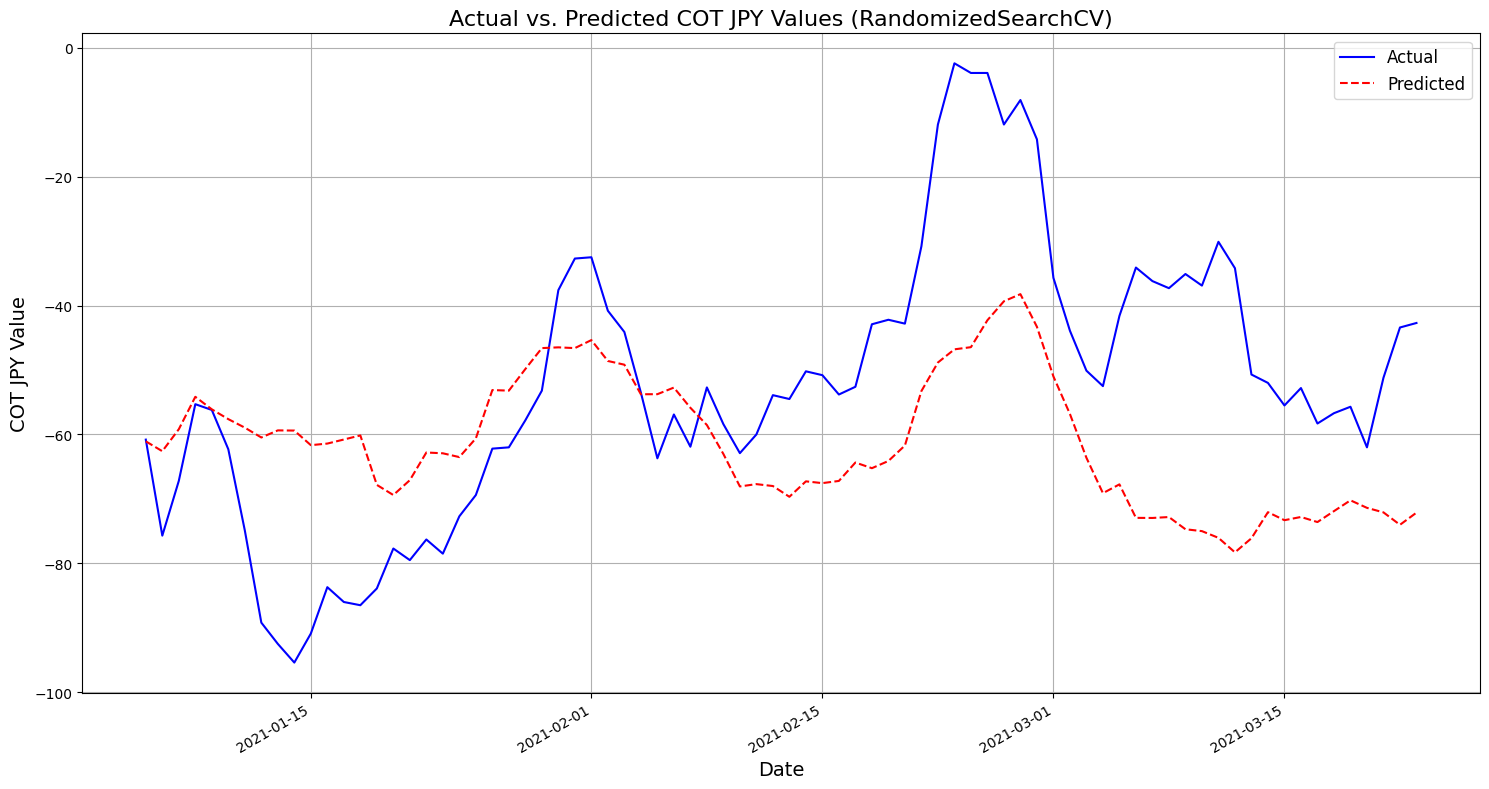

In [35]:
# Plot actual vs. predicted on original scale for RandomizedSearchCV
plot_actual_vs_predicted_original(
    dates_test=dates_test,
    y_test_original=y_test_original,
    y_pred_original=y_pred_random_original,
    title='Actual vs. Predicted COT JPY Values (RandomizedSearchCV)',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8),
    actual_color='blue',
    predicted_color='red'
)

## Optuna

In [36]:
def objective(trial):
    """
    Objective function for Optuna to minimize.

    Parameters:
    - trial: Optuna trial object.

    Returns:
    - score: float, the objective metric to minimize.
    """
    # Define the hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    # Initialize the XGBoost Regressor with the suggested parameters
    xgb = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **param
    )

    # Initialize TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # Initialize list to store cross-validation scores
    cv_scores = []

    # Perform cross-validation
    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train[train_idx], X_train[valid_idx]
        y_tr, y_val = y_train[train_idx], y_train[valid_idx]

        # Fit the model
        xgb.fit(X_tr, y_tr)

        # Predict on the validation set
        y_pred_val = xgb.predict(X_val)

        # Compute the Mean Squared Error
        mse = mean_squared_error(y_val, y_pred_val)
        cv_scores.append(mse)

    # Compute the average MSE across folds
    avg_mse = np.mean(cv_scores)

    return avg_mse

In [37]:
# Initialize the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42), study_name='XGBoost_Optuna_Optimization')

[I 2024-10-21 00:19:41,176] A new study created in memory with name: XGBoost_Optuna_Optimization


In [38]:
# Optimize the objective function
study.optimize(objective, n_trials=100, timeout=600)

[I 2024-10-21 00:19:42,122] Trial 0 finished with value: 119.07675546588902 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.15599452033620265, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 119.07675546588902.
[I 2024-10-21 00:19:44,408] Trial 1 finished with value: 120.40607476300144 and parameters: {'n_estimators': 641, 'learning_rate': 0.11114989443094977, 'max_depth': 3, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 0.21233911067827616, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 119.07675546588902.
[I 2024-10-21 00:19:49,171] Trial 2 finished with value: 110.62619479975463 and parameters: {'n_estimators': 374, 'learning_rate': 0.05958389350068958, 'max_depth': 6, 'subsample': 0.645614570099021, 'colsample_bytre

In [39]:
# Retrieve the best parameters and best score
best_params_optuna = study.best_params
best_score_optuna = study.best_value

print(f"Best Parameters (Optuna): {best_params_optuna}")
print(f"Best CV Score (MSE): {best_score_optuna:.4f}")

Best Parameters (Optuna): {'n_estimators': 155, 'learning_rate': 0.010681064342127606, 'max_depth': 3, 'subsample': 0.579025375888861, 'colsample_bytree': 0.8905104881558571, 'gamma': 0.6157227541363803, 'reg_alpha': 0.20698901179067475, 'reg_lambda': 2.256288928261326}
Best CV Score (MSE): 103.9889


In [40]:
# Initialize the XGBoost Regressor with the best hyperparameters from Optuna
best_model_optuna = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params_optuna
)

In [41]:
# Fit the model on the entire training data
best_model_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8905104881558571, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.6157227541363803,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.010681064342127606,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=155, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
# Predict on the testing data
y_pred_optuna = best_model_optuna.predict(X_test)

In [43]:
# Reconstruct predictions to original scale using iterative method
y_pred_optuna_original = reconstruct_original_scale_iterative(y_original_train_last, y_pred_optuna)
print("Reconstructed predicted values on original scale (Optuna):")
print(y_pred_optuna_original)

Reconstructed predicted values on original scale (Optuna):
[-62.65476637 -65.88903718 -64.3499382  -62.34824901 -63.44749146
 -66.08348756 -68.30198865 -70.57622366 -72.05905776 -72.63581388
 -73.49525003 -72.26639657 -70.79419546 -68.86801009 -71.08476906
 -72.17917233 -73.68930333 -71.37192194 -71.26071781 -69.84649319
 -66.28047842 -63.2971856  -62.14345962 -59.03119308 -56.94986326
 -55.12032849 -53.8562035  -52.81707126 -56.13492829 -57.50484592
 -60.63038761 -62.94852239 -61.42325503 -63.10045201 -63.89020908
 -67.23915375 -70.75157774 -71.91011083 -71.32719863 -72.10980279
 -70.48950488 -71.66764576 -70.7371406  -68.65858215 -68.07415444
 -66.4937777  -65.25754851 -61.39318532 -58.39322418 -57.89787865
 -58.21448586 -57.07516942 -57.54721421 -55.54977483 -58.87059969
 -63.66493887 -66.2146799  -69.51345748 -71.94022912 -71.37297422
 -72.51303298 -73.5239951  -73.86504421 -74.8919141  -76.78483054
 -76.62809918 -76.92912251 -76.38809514 -74.61444712 -74.99238724
 -73.18651623 -74

In [44]:
# Compute evaluation metrics
mse_optuna = mean_squared_error(y_test_original, y_pred_optuna_original)
rmse_optuna = np.sqrt(mse_optuna)
mae_optuna = mean_absolute_error(y_test_original, y_pred_optuna_original)

print(f"Optuna - Model Performance on Test Set:")
print(f"Mean Squared Error (MSE): {mse_optuna:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_optuna:.4f}")
print(f"Mean Absolute Error (MAE): {mae_optuna:.4f}")

Optuna - Model Performance on Test Set:
Mean Squared Error (MSE): 587.9013
Root Mean Squared Error (RMSE): 24.2467
Mean Absolute Error (MAE): 19.5996


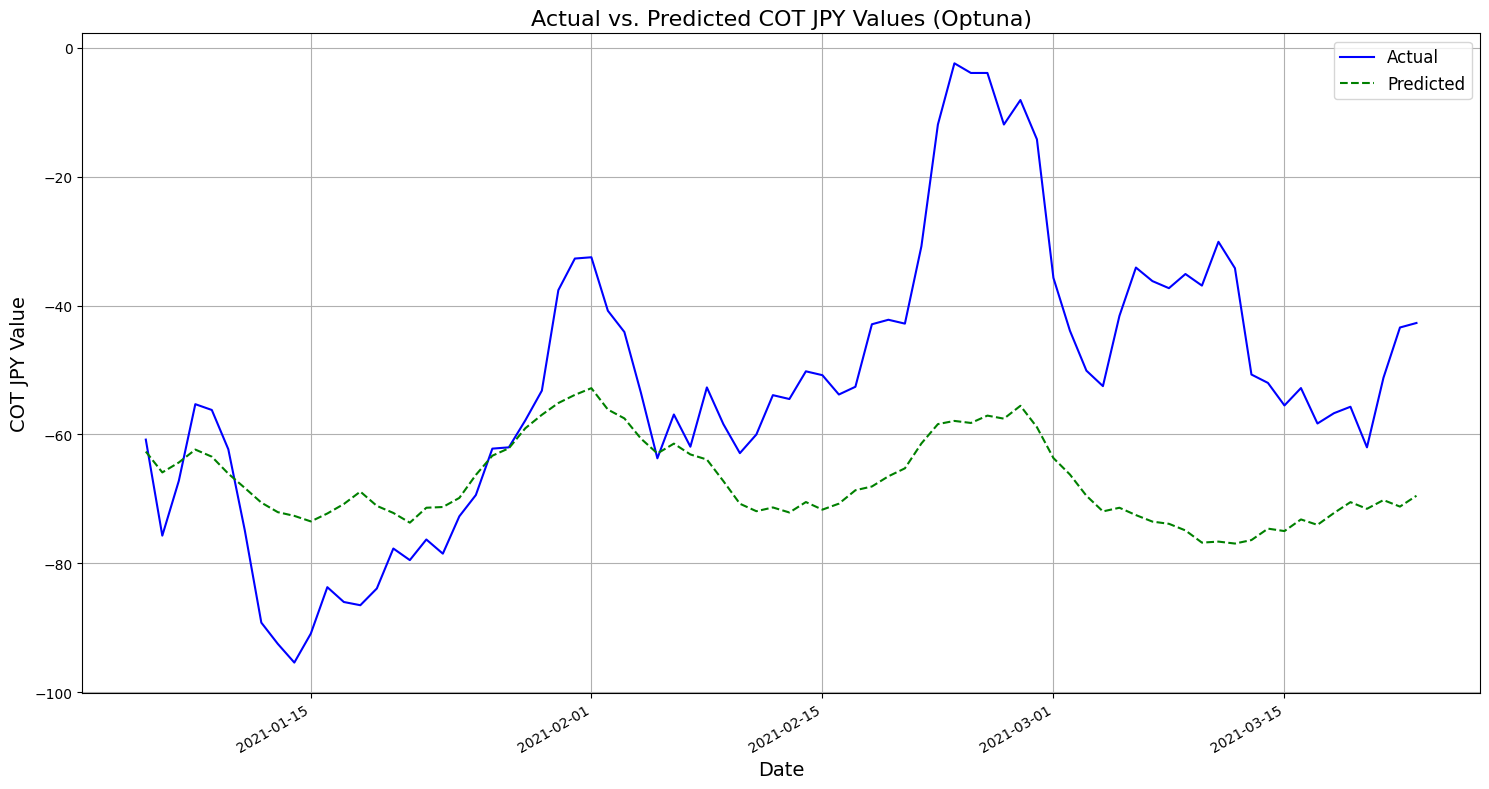

In [45]:
# Plot actual vs. predicted on original scale for Optuna
plot_actual_vs_predicted_original(
    dates_test=dates_test,
    y_test_original=y_test_original,
    y_pred_original=y_pred_optuna_original,
    title='Actual vs. Predicted COT JPY Values (Optuna)',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8),
    actual_color='blue',
    predicted_color='green'
)

## Comparison

In [46]:
# Define a dictionary of model predictions
model_predictions = {
    'XGBoost': y_pred_original,
    'RandomizedSearchCV': y_pred_random_original,
    'Optuna': y_pred_optuna_original
}

In [47]:
def plot_all_model_predictions(dates_test, y_test_original, predictions_dict,
                               title='Actual vs. Predicted COT JPY Values',
                               xlabel='Date', ylabel='COT JPY Value',
                               figsize=(15, 8)):
    """
    Plots the actual values and multiple model predictions on a single line plot.

    Parameters:
    - dates_test: pandas Series or array-like, dates corresponding to the test set.
    - y_test_original: numpy array or list, actual target values on original scale.
    - predictions_dict: dict, keys are model names (str) and values are predicted arrays.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - figsize: tuple, size of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=figsize)

    # Plot actual values
    plt.plot(dates_test, y_test_original, label='Actual', color='blue', linewidth=2)

    # Define a color palette for different models
    color_palette = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']

    # Plot each model's predictions
    for idx, (model_name, y_pred) in enumerate(predictions_dict.items()):
        color = color_palette[idx % len(color_palette)]  # Cycle through colors if more models than colors
        plt.plot(dates_test, y_pred, label=model_name, color=color, linestyle='--', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Improve x-axis date formatting
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

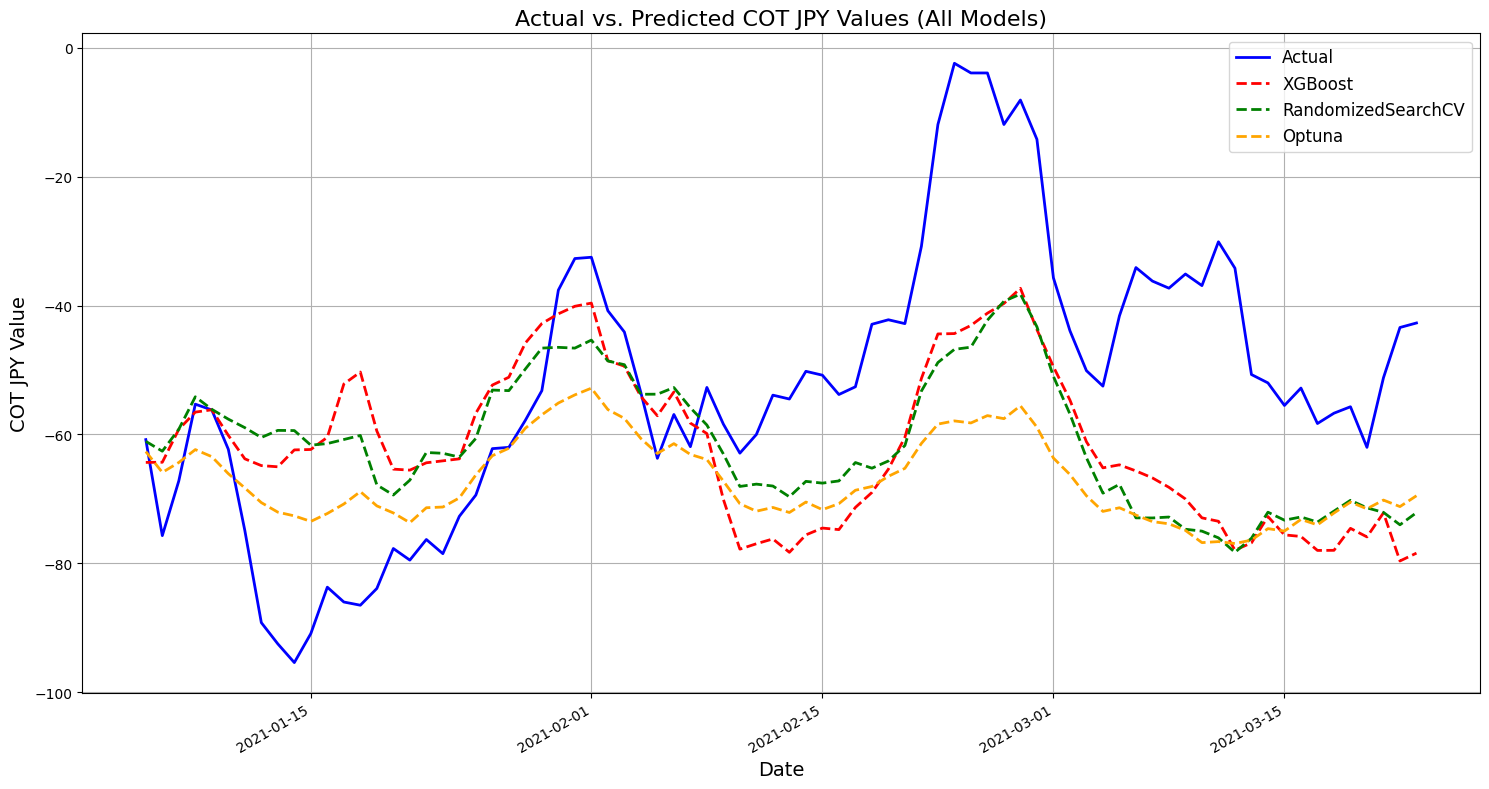

In [48]:
# Plot all model predictions together
plot_all_model_predictions(
    dates_test=dates_test,
    y_test_original=y_test_original,
    predictions_dict=model_predictions,
    title='Actual vs. Predicted COT JPY Values (All Models)',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8)
)

In [49]:
def compare_models_metrics(y_test_original, predictions_dict,
                           metric_names=['MSE', 'RMSE', 'MAE']):
    """
    Computes and compares evaluation metrics for multiple models.

    Parameters:
    - y_test_original: numpy array or list, actual target values on original scale.
    - predictions_dict: dict, keys are model names (str) and values are predicted arrays.
    - metric_names: list of str, names of metrics to compute.

    Returns:
    - metrics_df: pandas DataFrame containing the computed metrics for each model.
    - None (displays plots)
    """
    # Initialize a list to store metrics
    metrics_list = []

    for model_name, y_pred in predictions_dict.items():
        mse = mean_squared_error(y_test_original, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_original, y_pred)

        metrics_list.append({
            'Model': model_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae
        })

    # Create a DataFrame from the metrics list
    metrics_df = pd.DataFrame(metrics_list)

    # Display the metrics table
    print("Model Evaluation Metrics:")
    display(metrics_df)

    # Melt the DataFrame for easier plotting with seaborn
    metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Value')

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Create a bar plot for each metric
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Value', hue='Model', data=metrics_melted)
    plt.title('Comparison of Evaluation Metrics Across Models', fontsize=16)
    plt.xlabel('Evaluation Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(title='Model', fontsize=12)
    plt.tight_layout()
    plt.show()

    return metrics_df

Model Evaluation Metrics:


,Model,MSE,RMSE,MAE
0,XGBoost,507.625147,22.530538,19.501767
1,RandomizedSearchCV,491.840623,22.177480,18.686911
2,Optuna,587.901294,24.246676,19.599590


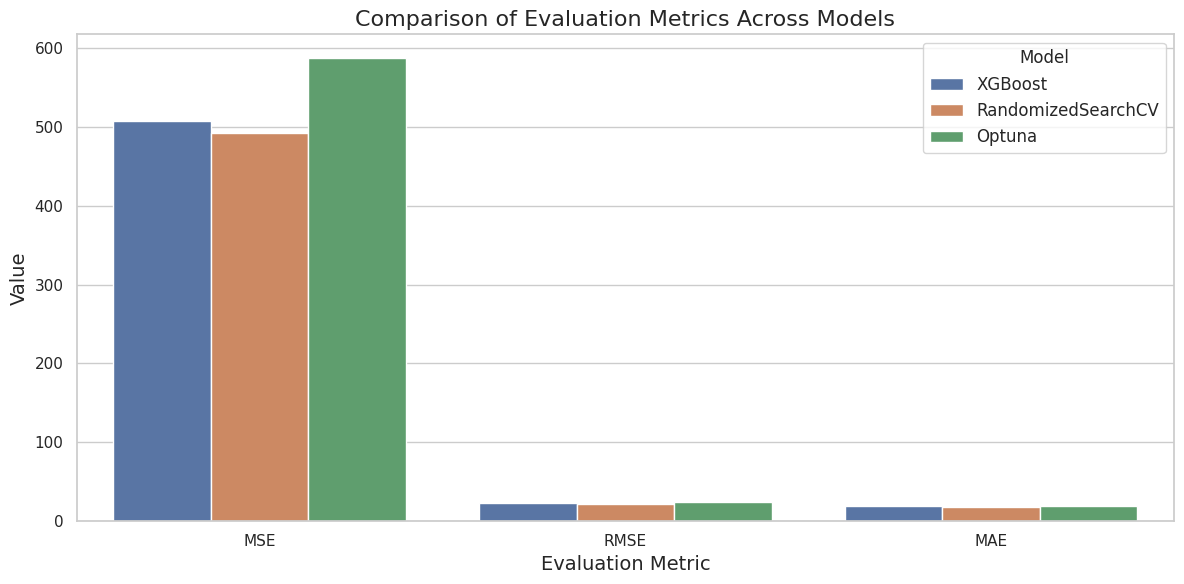

In [50]:
# Compare evaluation metrics for all models
metrics_df = compare_models_metrics(
    y_test_original=y_test_original,
    predictions_dict=model_predictions,
    metric_names=['MSE', 'RMSE', 'MAE']
)

In [51]:
def plot_residuals(dates_test, y_test_original, predictions_dict,
                  figsize=(15, 8)):
    """
    Plots residuals for each model.

    Parameters:
    - dates_test: pandas Series or array-like, dates corresponding to the test set.
    - y_test_original: numpy array or list, actual target values on original scale.
    - predictions_dict: dict, keys are model names (str) and values are predicted arrays.
    - figsize: tuple, size of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=figsize)

    for model_name, y_pred in predictions_dict.items():
        residuals = y_test_original - y_pred
        plt.plot(dates_test, residuals, label=f'{model_name} Residuals', linestyle='-', alpha=0.7)

    plt.title('Residuals of Models', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Residual (Actual - Predicted)', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Improve x-axis date formatting
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

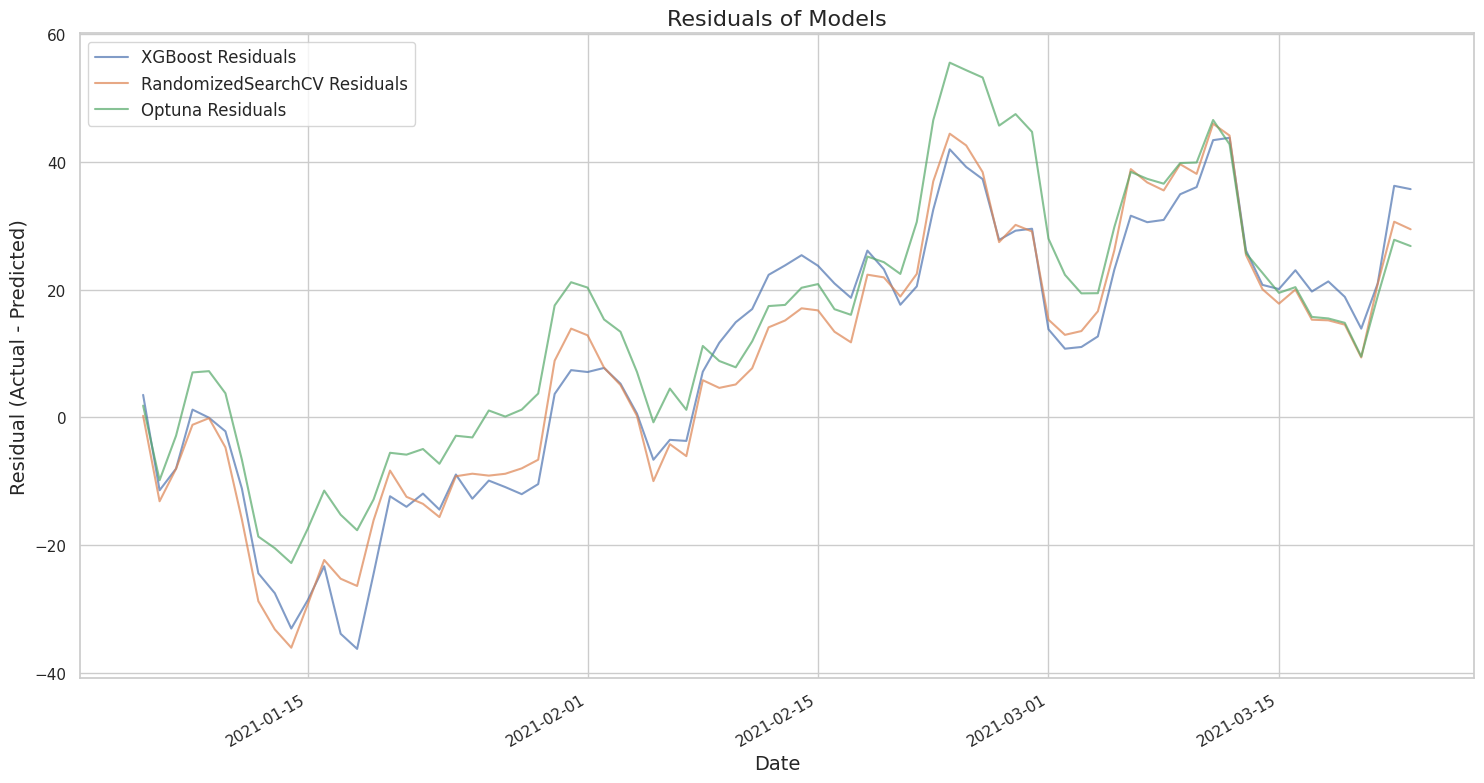

In [52]:
# Plot residuals for all models
plot_residuals(
    dates_test=dates_test,
    y_test_original=y_test_original,
    predictions_dict=model_predictions,
    figsize=(15, 8)
)

# With STL Decomposition

In [53]:
def perform_stl_decomposition(df, seasonal_period=7, robust=True):
    """
    Performs STL decomposition on the time series data.

    Parameters:
    - df: pandas DataFrame with a date index and a single data column.
    - seasonal_period: int, the number of observations per cycle (e.g., 7 for weekly seasonality).
    - robust: bool, whether to use a robust trend and seasonal extraction.

    Returns:
    - stl_result: statsmodels STL decomposition result object.
    """
    stl = STL(df['COT_JPY_Value'], period=seasonal_period, robust=robust)
    stl_result = stl.fit()
    return stl_result

In [54]:
# Perform STL decomposition
seasonal_period = 30
stl_result = perform_stl_decomposition(df, seasonal_period=seasonal_period)

In [55]:
def plot_stl_decomposition(stl_result, title='STL Decomposition of COT JPY Value'):
    """
    Plots the STL decomposition results.

    Parameters:
    - stl_result: statsmodels STL decomposition result object.
    - title: str, title of the plot.

    Returns:
    - None
    """
    fig = stl_result.plot()
    fig.set_size_inches(15, 9)
    plt.suptitle(title, fontsize=16)
    plt.show()

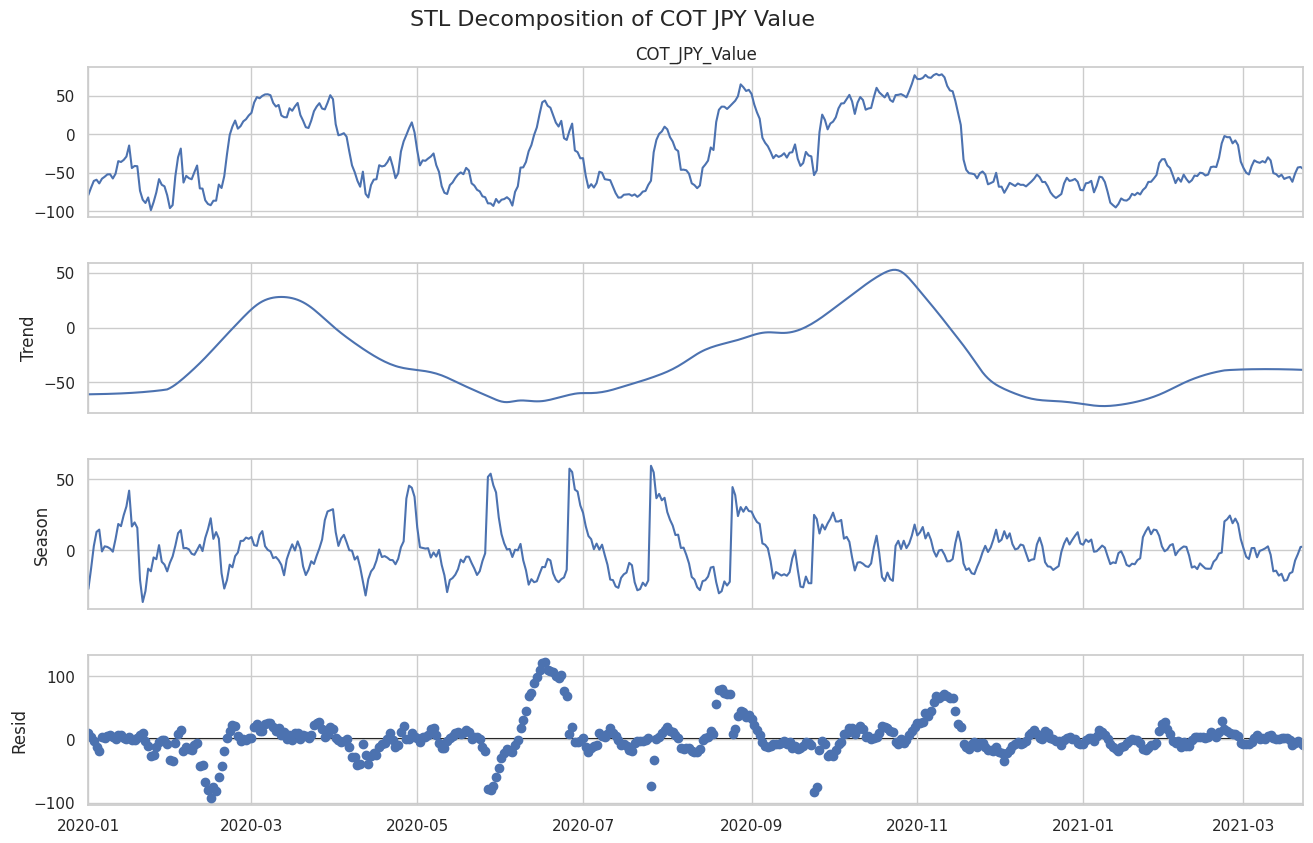

In [56]:
# Plot the decomposition
plot_stl_decomposition(stl_result)

In [57]:
def prepare_stl_features(stl_result):
    """
    Extracts Trend and Residual components from STL decomposition.

    Parameters:
    - stl_result: statsmodels STL decomposition result object.

    Returns:
    - df_features: pandas DataFrame containing Trend and Residual.
    """
    df_features = pd.DataFrame({
        'Trend': stl_result.trend,
        'Residual': stl_result.resid
    }, index=stl_result.trend.index)
    return df_features

df_features = prepare_stl_features(stl_result)

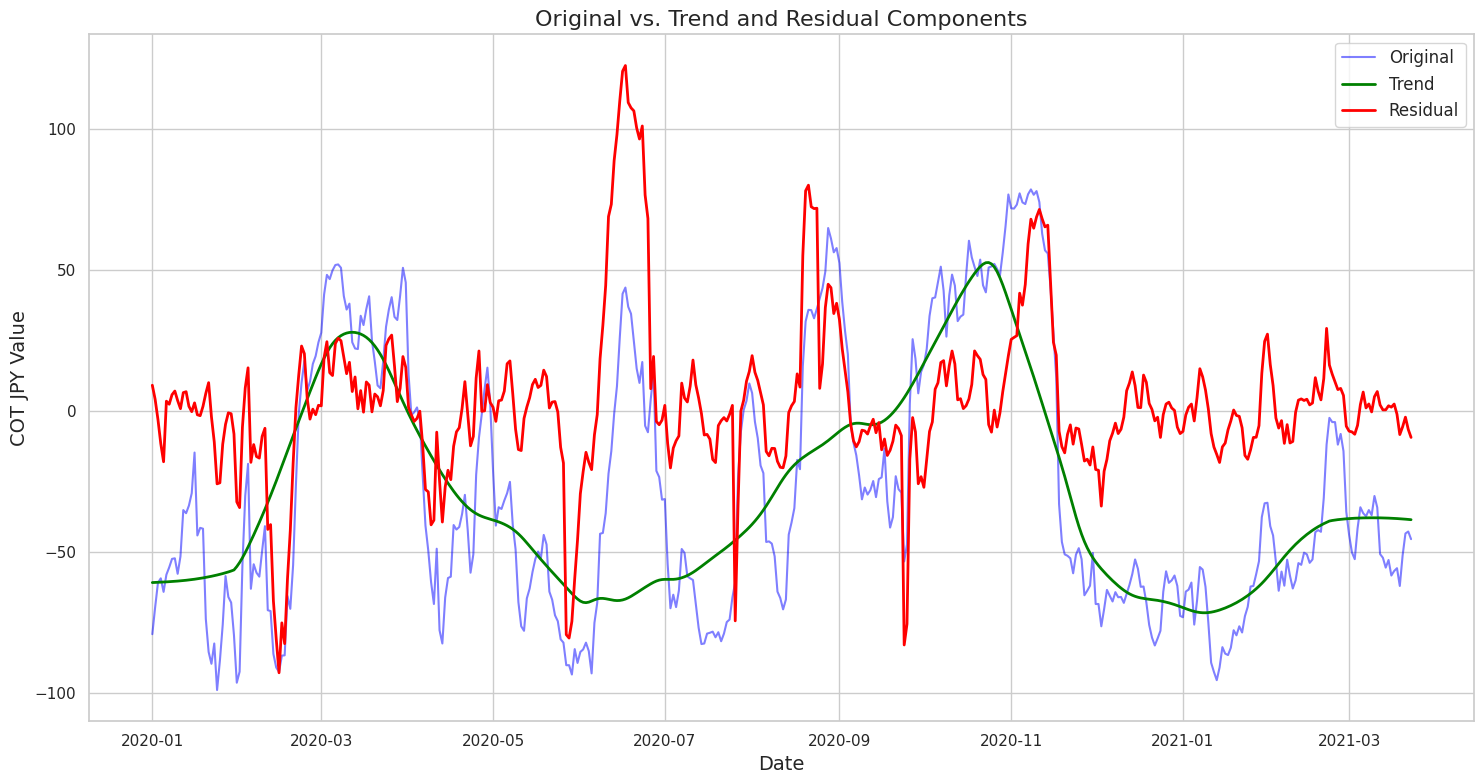

In [58]:
def plot_original_vs_components(df, df_features, title='Original vs. Trend and Residual Components'):
    """
    Plots the original series alongside Trend and Residual components.

    Parameters:
    - df: pandas DataFrame with the original data.
    - df_features: pandas DataFrame with Trend and Residual.
    - title: str, title of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 8))
    plt.plot(df.index, df['COT_JPY_Value'], label='Original', color='blue', alpha=0.5)
    plt.plot(df_features.index, df_features['Trend'], label='Trend', color='green', linewidth=2)
    plt.plot(df_features.index, df_features['Residual'], label='Residual', color='red', linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('COT JPY Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_original_vs_components(df, df_features)

In [59]:
def create_lag_features(data, num_lags):
    """
    Creates lag features from the deseasonalized data.

    Parameters:
    - data: pandas Series, deseasonalized data.
    - num_lags: int, number of lag features.

    Returns:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    """
    X, y = [], []
    for i in range(len(data) - num_lags):
        X.append(data[i:i + num_lags].values)
        y.append(data[i + num_lags])

    X = np.array(X)
    y = np.array(y)
    print(f"Total samples after creating lag features: {X.shape[0]}")
    return X, y

In [60]:
# Parameters
NUM_LAGS = 60  # Number of lag features

# Create lag features
X_residual, y_residual = create_lag_features(df_features['Residual'], NUM_LAGS)

Total samples after creating lag features: 388


In [61]:
def split_data(X, y, train_split):
    """
    Splits the data into training and testing sets based on the split ratio.

    Parameters:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    - train_split: float, proportion of data to use for training (e.g., 0.80 for 80%).

    Returns:
    - X_train: numpy array, training features.
    - y_train: numpy array, training targets.
    - X_test: numpy array, testing features.
    - y_test: numpy array, testing targets.
    """
    split_idx = int(len(X) * train_split)
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_test, y_test = X[split_idx:], y[split_idx:]

    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    return X_train, y_train, X_test, y_test

In [62]:
def align_dates(df, stl_result, num_lags, train_split):
    """
    Aligns dates with the target variable after lagging.

    Parameters:
    - df: pandas DataFrame with the original data.
    - stl_result: statsmodels STL decomposition result object.
    - num_lags: int, number of lag features.
    - train_split: float, proportion of data to use for training.

    Returns:
    - dates_train: pandas Series for training dates.
    - dates_test: pandas Series for testing dates.
    """
    dates = df.index[num_lags:]
    split_idx = int((len(stl_result.resid) - num_lags) * train_split)
    dates_train = dates[:split_idx]
    dates_test = dates[split_idx:]
    print(f"Training dates range from {dates_train[0]} to {dates_train[-1]}")
    print(f"Testing dates range from {dates_test[0]} to {dates_test[-1]}")
    return dates_train, dates_test

In [63]:
# Parameters
TRAIN_SPLIT = 0.80  # 80% for training

# Split the data
X_train, y_train, X_test, y_test = split_data(X_residual, y_residual, TRAIN_SPLIT)

# Align dates
dates_train, dates_test = align_dates(df, stl_result, NUM_LAGS, TRAIN_SPLIT)

Training samples: 310
Testing samples: 78
Training dates range from 2020-03-01 00:00:00 to 2021-01-04 00:00:00
Testing dates range from 2021-01-05 00:00:00 to 2021-03-23 00:00:00


In [64]:
def train_xgboost(X_train, y_train, params=None):
    """
    Trains an XGBoost regressor.

    Parameters:
    - X_train: numpy array, training features.
    - y_train: numpy array, training targets.
    - params: dict, hyperparameters for XGBoost. If None, defaults are used.

    Returns:
    - model: trained XGBoost regressor.
    """
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'random_state': 42
        }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

In [65]:
# Train the baseline XGBoost model
baseline_model = train_xgboost(X_train, y_train)

In [66]:
def get_last_original_value(df, stl_result, num_lags, train_split):
    """
    Retrieves the last known original value from the training set.

    Parameters:
    - df: pandas DataFrame with the original data.
    - stl_result: statsmodels STL decomposition result object.
    - num_lags: int, number of lag features.
    - train_split: float, proportion of data used for training.

    Returns:
    - y_original_last: float, the last known original value from the training set.
    """
    total_samples = len(X_train)
    last_train_index = num_lags + total_samples - 1
    y_original_last = df['COT_JPY_Value'].iloc[last_train_index]
    print(f"Last original value in training set: {y_original_last}")
    return y_original_last

y_original_last = get_last_original_value(df, stl_result, NUM_LAGS, TRAIN_SPLIT)

Last original value in training set: -60.8


In [67]:
def reconstruct_predictions_with_stl(y_original_last, y_pred_residual, stl_result, num_lags):
    """
    Reconstructs the predictions to the original scale by adding Trend and Seasonal components.

    Parameters:
    - y_original_last: float, the last known original value from the training set.
    - y_pred_residual: numpy array, predicted Residual values.
    - stl_result: statsmodels STL decomposition result object.
    - num_lags: int, number of lag features.

    Returns:
    - y_pred_original: numpy array, reconstructed predictions on the original scale.
    """
    y_pred_original = []
    current = y_original_last

    # Extract the seasonal component corresponding to the forecast horizon
    # For simplicity, assume the seasonal component repeats
    seasonal = stl_result.seasonal[-num_lags:]

    for i in range(len(y_pred_residual)):
        current += y_pred_residual[i]  # Reverse differencing
        seasonal_component = seasonal[i % len(seasonal)]  # Add seasonal component
        # Add Trend component
        trend_component = stl_result.trend[num_lags + len(y_train) + i]
        # Final prediction on original scale
        y_pred_original.append(current + trend_component + seasonal_component)

    return np.array(y_pred_original)

In [68]:
# Make predictions on the testing data
y_pred_residual = baseline_model.predict(X_test)

# Reconstruct predictions to the original scale
y_pred_original = reconstruct_predictions_with_stl(y_original_last, y_pred_residual, stl_result, NUM_LAGS)
print("Reconstructed predicted values on original scale:")
print(y_pred_original)

Reconstructed predicted values on original scale:
[-117.12061457 -111.27976052 -106.95934026 -104.41960073  -91.37047172
  -79.75051535  -85.05637448 -101.47089787 -122.80597287 -136.65174338
 -155.61664778 -203.59362859 -265.77266542 -272.57421019 -275.54714395
 -280.01252528 -283.39474457 -290.38787159 -303.57509315 -310.79545281
 -323.80818807 -332.72968187 -339.10552993 -348.10762354 -350.00062965
 -332.39201077 -305.39889895 -273.38796515 -252.87473769 -238.16832335
 -211.11179483 -214.01037267 -208.66649117 -226.1012834  -226.28005189
 -242.7908274  -261.02931811 -266.75880259 -267.69393887 -262.22266438
 -247.8617183  -242.3051882  -249.194976   -241.45939284 -231.25858888
 -219.60142029 -207.90302535 -197.620177   -177.77217965 -165.40122842
 -154.04619559 -139.02645379 -130.86964538 -117.74313336 -108.01461591
 -111.90525095 -111.38503868 -120.53725289 -128.6305545  -135.76397054
 -131.49906917 -121.57592513 -116.98391914 -117.12864191 -111.31773168
 -104.71862138  -96.9077772

In [69]:
def evaluate_model(y_true, y_pred):
    """
    Computes evaluation metrics for the model.

    Parameters:
    - y_true: numpy array or list, actual target values on original scale.
    - y_pred: numpy array or list, predicted target values on original scale.

    Returns:
    - metrics: dict, containing MSE, RMSE, and MAE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

    return metrics

In [70]:
def display_evaluation_metrics(metrics, model_name='Model'):
    """
    Displays evaluation metrics.

    Parameters:
    - metrics: dict, containing evaluation metrics.
    - model_name: str, name of the model.

    Returns:
    - None
    """
    print(f"{model_name} Performance on Test Set:")
    print(f"Mean Squared Error (MSE): {metrics['MSE']:.4f}")
    print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
    print("-" * 40)

In [71]:
def get_actual_test_values(df, num_lags, train_split):
    """
    Retrieves the actual test set values on the original scale.

    Parameters:
    - df: pandas DataFrame with the original data.
    - num_lags: int, number of lag features.
    - train_split: float, proportion of data used for training.

    Returns:
    - y_test_original: numpy array, actual test set values on original scale.
    """
    # Calculate the starting index for the test set
    total_samples = len(X_train)
    start_test_index = num_lags + total_samples
    end_test_index = start_test_index + len(y_test)

    y_test_original = df['COT_JPY_Value'].iloc[start_test_index:end_test_index].values
    print("Actual test values on original scale:")
    print(y_test_original)
    return y_test_original

In [72]:
# Get the actual test values
y_test_original = get_actual_test_values(df, NUM_LAGS, TRAIN_SPLIT)

Actual test values on original scale:
[-75.7 -67.2 -55.3 -56.2 -62.3 -74.9 -89.2 -92.5 -95.4 -90.9 -83.7 -86.
 -86.5 -83.9 -77.7 -79.5 -76.3 -78.5 -72.7 -69.4 -62.2 -62.  -57.8 -53.2
 -37.6 -32.7 -32.5 -40.8 -44.1 -53.5 -63.7 -56.9 -61.9 -52.7 -58.4 -62.9
 -60.  -53.9 -54.5 -50.2 -50.8 -53.8 -52.6 -42.9 -42.2 -42.8 -30.8 -11.9
  -2.4  -3.9  -3.9 -11.9  -8.1 -14.2 -35.7 -43.9 -50.1 -52.5 -41.6 -34.1
 -36.2 -37.3 -35.1 -36.9 -30.1 -34.2 -50.7 -52.  -55.5 -52.8 -58.3 -56.7
 -55.7 -62.  -51.2 -43.4 -42.7 -45.4]


In [73]:
# Evaluate the baseline model
metrics_baseline = evaluate_model(y_test_original, y_pred_original)
display_evaluation_metrics(metrics_baseline, model_name='Baseline XGBoost with STL Decomposition')

Baseline XGBoost with STL Decomposition Performance on Test Set:
Mean Squared Error (MSE): 25413.8288
Root Mean Squared Error (RMSE): 159.4172
Mean Absolute Error (MAE): 139.2169
----------------------------------------


In [74]:
def plot_actual_vs_predicted_original(dates_test, y_test_original, y_pred_original,
                                      title='Actual vs. Predicted COT JPY Values',
                                      xlabel='Date', ylabel='COT JPY Value',
                                      figsize=(15, 8), actual_color='blue', predicted_color='red',
                                      legend_loc='upper left'):
    """
    Plots the actual versus predicted values on the original scale.

    Parameters:
    - dates_test: pandas Series or array-like, dates corresponding to the test set.
    - y_test_original: numpy array or list, actual target values on original scale.
    - y_pred_original: numpy array or list, predicted target values on original scale.
    - title: str, title of the plot.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - figsize: tuple, size of the plot.
    - actual_color: str, color for the actual values.
    - predicted_color: str, color for the predicted values.
    - legend_loc: str, location of the legend.

    Returns:
    - None
    """
    plt.figure(figsize=figsize)

    plt.plot(dates_test, y_test_original, label='Actual', color=actual_color, linewidth=2)
    plt.plot(dates_test, y_pred_original, label='Predicted', color=predicted_color, linestyle='--', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(loc=legend_loc, fontsize=12)
    plt.grid(True)

    # Improve x-axis date formatting
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

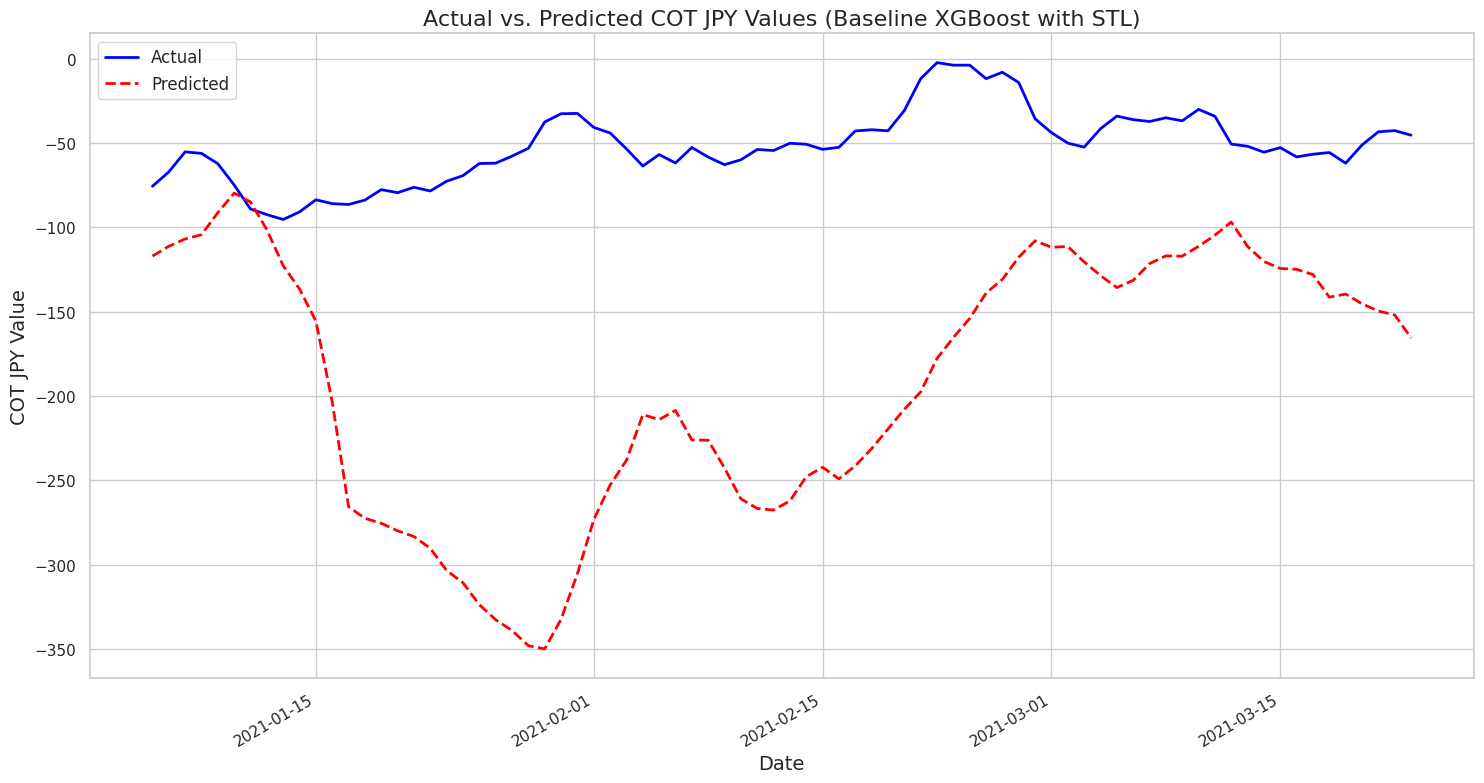

In [75]:
# Plot actual vs. predicted on original scale for the baseline model
plot_actual_vs_predicted_original(
    dates_test=dates_test,
    y_test_original=y_test_original,
    y_pred_original=y_pred_original,
    title='Actual vs. Predicted COT JPY Values (Baseline XGBoost with STL)',
    xlabel='Date',
    ylabel='COT JPY Value',
    figsize=(15, 8),
    actual_color='blue',
    predicted_color='red'
)

# With Filters

In [76]:
def apply_kalman_filter(series):
    """
    Applies the Kalman Filter to smooth the time series data.

    Parameters:
    - series: pandas Series, the original time series data.

    Returns:
    - filtered_series: pandas Series, smoothed time series.
    """
    kf = KalmanFilter(initial_state_mean=series.iloc[0], n_dim_obs=1)
    state_means, _ = kf.filter(series.values)
    filtered_series = pd.Series(state_means.flatten(), index=series.index)
    return filtered_series

In [77]:
def apply_moving_average(series, window=7):
    """
    Applies a Moving Average filter to smooth the time series data.

    Parameters:
    - series: pandas Series, the original time series data.
    - window: int, the window size for moving average.

    Returns:
    - filtered_series: pandas Series, smoothed time series.
    """
    filtered_series = series.rolling(window=window, min_periods=1, center=False).mean()
    return filtered_series

In [78]:
def apply_exponential_smoothing(series, trend=None, seasonal=None, seasonal_periods=None):
    """
    Applies Exponential Smoothing to smooth the time series data.

    Parameters:
    - series: pandas Series, the original time series data.
    - trend: str or None, type of trend component ('add', 'mul', or None).
    - seasonal: str or None, type of seasonal component ('add', 'mul', or None).
    - seasonal_periods: int or None, number of periods in a complete seasonal cycle.

    Returns:
    - filtered_series: pandas Series, smoothed time series.
    """
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    fitted_model = model.fit(optimized=True)
    filtered_series = fitted_model.fittedvalues
    return filtered_series

In [79]:
def apply_savgol_filter(series, window_length=11, polyorder=2):
    """
    Applies the Savitzky-Golay filter to smooth the time series data.

    Parameters:
    - series: pandas Series, the original time series data.
    - window_length: int, the length of the filter window (must be odd).
    - polyorder: int, the order of the polynomial used to fit the samples.

    Returns:
    - filtered_series: pandas Series, smoothed time series.
    """
    # Ensure window_length is odd and greater than polyorder
    if window_length % 2 == 0:
        window_length += 1
    if window_length <= polyorder:
        window_length = polyorder + 2 + (polyorder % 2)

    filtered_values = savgol_filter(series.values, window_length=window_length, polyorder=polyorder)
    filtered_series = pd.Series(filtered_values, index=series.index)
    return filtered_series

In [80]:
def apply_all_filters(df, window_ma=7, trend='add', seasonal='add', seasonal_periods=7, savgol_window=11, savgol_polyorder=2):
    """
    Applies multiple filters to the time series data.

    Parameters:
    - df: pandas DataFrame, original time series data with 'COT_JPY_Value' column.
    - window_ma: int, window size for Moving Average Filter.
    - trend: str or None, type of trend component for Exponential Smoothing.
    - seasonal: str or None, type of seasonal component for Exponential Smoothing.
    - seasonal_periods: int or None, number of periods in a complete seasonal cycle for Exponential Smoothing.
    - savgol_window: int, window length for Savitzky-Golay Filter.
    - savgol_polyorder: int, polynomial order for Savitzky-Golay Filter.

    Returns:
    - filtered_dict: dict, keys are filter names and values are filtered pandas Series.
    """
    filtered_dict = {}

    # Kalman Filter
    kalman_filtered = apply_kalman_filter(df['COT_JPY_Value'])
    filtered_dict['Kalman Filter'] = kalman_filtered

    # Moving Average Filter
    ma_filtered = apply_moving_average(df['COT_JPY_Value'], window=window_ma)
    filtered_dict['Moving Average'] = ma_filtered

    # Exponential Smoothing Filter
    exp_smooth_filtered = apply_exponential_smoothing(df['COT_JPY_Value'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    filtered_dict['Exponential Smoothing'] = exp_smooth_filtered

    # Savitzky-Golay Filter
    savgol_filtered = apply_savgol_filter(df['COT_JPY_Value'], window_length=savgol_window, polyorder=savgol_polyorder)
    filtered_dict['Savitzky-Golay'] = savgol_filtered

    return filtered_dict

In [81]:
# Apply all filters
filtered_series_dict = apply_all_filters(
    df,
    window_ma=7,
    trend='add',
    seasonal='add',
    seasonal_periods=7,
    savgol_window=11,
    savgol_polyorder=2
)

In [82]:
# Display first few rows of each filtered series
for filter_name, series in filtered_series_dict.items():
    print(f"\nFilter: {filter_name}")
    display(series.head())


Filter: Kalman Filter


,0
2020-01-01,-79.100000
2020-01-02,-73.400000
2020-01-03,-65.707692
2020-01-04,-61.750000
2020-01-05,-63.202247



Filter: Moving Average


,COT_JPY_Value
2020-01-01,-79.100000
2020-01-02,-74.350000
2020-01-03,-69.866667
2020-01-04,-67.225000
2020-01-05,-66.600000



Filter: Exponential Smoothing


,0
2020-01-01,-78.954400
2020-01-02,-81.124216
2020-01-03,-70.205545
2020-01-04,-57.435201
2020-01-05,-58.928160



Filter: Savitzky-Golay


,0
2020-01-01,-75.628671
2020-01-02,-70.520559
2020-01-03,-66.074452
2020-01-04,-62.290350
2020-01-05,-59.168252


In [83]:
# Initialize a dictionary to store metrics
metrics_results = {}

# Initialize a dictionary to store predictions
predictions_results = {}

In [84]:
def create_lag_features(series, num_lags=60):
    """
    Creates lag features for the residuals of the filtered series.

    Parameters:
    - series: pandas Series, residuals (original - filtered).
    - num_lags: int, number of lag features.

    Returns:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    """
    X, y = [], []
    for i in range(len(series) - num_lags):
        X.append(series[i:i + num_lags].values)
        y.append(series[i + num_lags])
    X = np.array(X)
    y = np.array(y)
    print(f"Created {X.shape[0]} samples with {num_lags} lag features.")
    return X, y

In [85]:
def split_train_test(X, y, train_size=0.8):
    """
    Splits the data into training and testing sets.

    Parameters:
    - X: numpy array, feature matrix.
    - y: numpy array, target vector.
    - train_size: float, proportion of data to use for training.

    Returns:
    - X_train: numpy array, training features.
    - y_train: numpy array, training targets.
    - X_test: numpy array, testing features.
    - y_test: numpy array, testing targets.
    """
    split_index = int(len(X) * train_size)
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    return X_train, y_train, X_test, y_test

In [86]:
def align_dates(df, num_lags=60, train_size=0.8):
    """
    Aligns dates with the target variable after lagging.

    Parameters:
    - df: pandas DataFrame, original time series data.
    - num_lags: int, number of lag features.
    - train_size: float, proportion of data to use for training.

    Returns:
    - dates_train: pandas Series, training dates.
    - dates_test: pandas Series, testing dates.
    """
    dates = df.index[num_lags:]
    split_index = int(len(dates) * train_size)
    dates_train = dates[:split_index]
    dates_test = dates[split_index:]
    print(f"Training dates from {dates_train[0]} to {dates_train[-1]}")
    print(f"Testing dates from {dates_test[0]} to {dates_test[-1]}")
    return dates_train, dates_test

In [87]:
def train_xgboost_model(X_train, y_train, params=None):
    """
    Trains an XGBoost regressor.

    Parameters:
    - X_train: numpy array, training features.
    - y_train: numpy array, training targets.
    - params: dict or None, hyperparameters for XGBoost. If None, defaults are used.

    Returns:
    - model: trained XGBoost regressor.
    """
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 5,
            'random_state': 42
        }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    return model

In [88]:
def reconstruct_predictions(original_series, filtered_series, y_pred_residual, num_lags=60):
    """
    Reconstructs the predictions to the original scale by adding the residuals to the filtered series.

    Parameters:
    - original_series: pandas Series, original time series data.
    - filtered_series: pandas Series, filtered time series data.
    - y_pred_residual: numpy array, predicted residuals.
    - num_lags: int, number of lag features.

    Returns:
    - y_pred_original: numpy array, predictions on the original scale.
    """
    # Extract the corresponding filtered series for the test set
    filtered_test = filtered_series.iloc[-len(y_pred_residual):].values
    # Reconstruct the original predictions
    y_pred_original = filtered_test + y_pred_residual
    return y_pred_original

In [89]:
def evaluate_model(y_true, y_pred):
    """
    Computes evaluation metrics for the model.

    Parameters:
    - y_true: numpy array or list, actual target values on original scale.
    - y_pred: numpy array or list, predicted target values on original scale.

    Returns:
    - metrics: dict, containing MSE, RMSE, and MAE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }
    return metrics

In [90]:
def display_metrics(metrics, model_filter_name):
    """
    Displays the evaluation metrics.

    Parameters:
    - metrics: dict, containing evaluation metrics.
    - model_filter_name: str, name of the model + filter combination.

    Returns:
    - None
    """
    print(f"Performance for {model_filter_name}:")
    print(f"  Mean Squared Error (MSE): {metrics['MSE']:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
    print("-" * 50)

In [91]:
# Define the number of lags
NUM_LAGS = 60
TRAIN_SIZE = 0.8

for filter_name, filtered_series in filtered_series_dict.items():
    print(f"\nProcessing Filter: {filter_name}")

    # Compute residuals
    residuals = df['COT_JPY_Value'] - filtered_series
    print("First 5 residuals:")
    display(residuals.head())

    # Create lag features
    X, y = create_lag_features(residuals, num_lags=NUM_LAGS)

    # Split into training and testing sets
    X_train, y_train, X_test, y_test = split_train_test(X, y, train_size=TRAIN_SIZE)

    # Align dates
    dates_train, dates_test = align_dates(df, num_lags=NUM_LAGS, train_size=TRAIN_SIZE)

    # Train XGBoost model
    model = train_xgboost_model(X_train, y_train)

    # Predict residuals
    y_pred_residual = model.predict(X_test)

    # Reconstruct predictions to original scale
    y_pred_original = reconstruct_predictions(df['COT_JPY_Value'], filtered_series, y_pred_residual, num_lags=NUM_LAGS)

    # Extract actual test values
    y_test_original = df['COT_JPY_Value'].iloc[-len(y_pred_original):].values

    # Evaluate the model
    metrics = evaluate_model(y_test_original, y_pred_original)
    display_metrics(metrics, f"{filter_name} + XGBoost")

    # Store metrics and predictions
    metrics_results[f"{filter_name} + XGBoost"] = metrics
    predictions_results[f"{filter_name} + XGBoost"] = y_pred_original


Processing Filter: Kalman Filter
First 5 residuals:


,0
2020-01-01,0.000000
2020-01-02,3.800000
2020-01-03,4.807692
2020-01-04,2.450000
2020-01-05,-0.897753


Created 388 samples with 60 lag features.
Training samples: 310
Testing samples: 78
Training dates from 2020-03-01 00:00:00 to 2021-01-04 00:00:00
Testing dates from 2021-01-05 00:00:00 to 2021-03-23 00:00:00
Performance for Kalman Filter + XGBoost:
  Mean Squared Error (MSE): 8.9694
  Root Mean Squared Error (RMSE): 2.9949
  Mean Absolute Error (MAE): 2.3463
--------------------------------------------------

Processing Filter: Moving Average
First 5 residuals:


,COT_JPY_Value
2020-01-01,0.000000
2020-01-02,4.750000
2020-01-03,8.966667
2020-01-04,7.925000
2020-01-05,2.500000


Created 388 samples with 60 lag features.
Training samples: 310
Testing samples: 78
Training dates from 2020-03-01 00:00:00 to 2021-01-04 00:00:00
Testing dates from 2021-01-05 00:00:00 to 2021-03-23 00:00:00
Performance for Moving Average + XGBoost:
  Mean Squared Error (MSE): 52.1390
  Root Mean Squared Error (RMSE): 7.2207
  Mean Absolute Error (MAE): 5.9791
--------------------------------------------------

Processing Filter: Exponential Smoothing
First 5 residuals:


,0
2020-01-01,-0.145600
2020-01-02,11.524216
2020-01-03,9.305545
2020-01-04,-1.864799
2020-01-05,-5.171840


Created 388 samples with 60 lag features.
Training samples: 310
Testing samples: 78
Training dates from 2020-03-01 00:00:00 to 2021-01-04 00:00:00
Testing dates from 2021-01-05 00:00:00 to 2021-03-23 00:00:00
Performance for Exponential Smoothing + XGBoost:
  Mean Squared Error (MSE): 56.7009
  Root Mean Squared Error (RMSE): 7.5300
  Mean Absolute Error (MAE): 5.9032
--------------------------------------------------

Processing Filter: Savitzky-Golay
First 5 residuals:


,0
2020-01-01,-3.471329
2020-01-02,0.920559
2020-01-03,5.174452
2020-01-04,2.990350
2020-01-05,-4.931748


Created 388 samples with 60 lag features.
Training samples: 310
Testing samples: 78
Training dates from 2020-03-01 00:00:00 to 2021-01-04 00:00:00
Testing dates from 2021-01-05 00:00:00 to 2021-03-23 00:00:00
Performance for Savitzky-Golay + XGBoost:
  Mean Squared Error (MSE): 18.6319
  Root Mean Squared Error (RMSE): 4.3165
  Mean Absolute Error (MAE): 3.3343
--------------------------------------------------


In [92]:
def plot_actual_vs_predicted(dates_test, y_test, predictions_dict, title='Actual vs. Predicted COT JPY Values'):
    """
    Plots the actual values and multiple model predictions on a single line plot.

    Parameters:
    - dates_test: pandas Series or array-like, dates corresponding to the test set.
    - y_test: numpy array or list, actual target values on original scale.
    - predictions_dict: dict, keys are model+filter names and values are predicted arrays.
    - title: str, title of the plot.

    Returns:
    - None
    """
    plt.figure(figsize=(15, 8))
    plt.plot(dates_test, y_test, label='Actual', color='black', linewidth=2)

    # Define a color palette
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown']

    for idx, (name, pred) in enumerate(predictions_dict.items()):
        plt.plot(dates_test, pred, label=name, color=colors[idx % len(colors)], linestyle='--', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('COT JPY Value', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

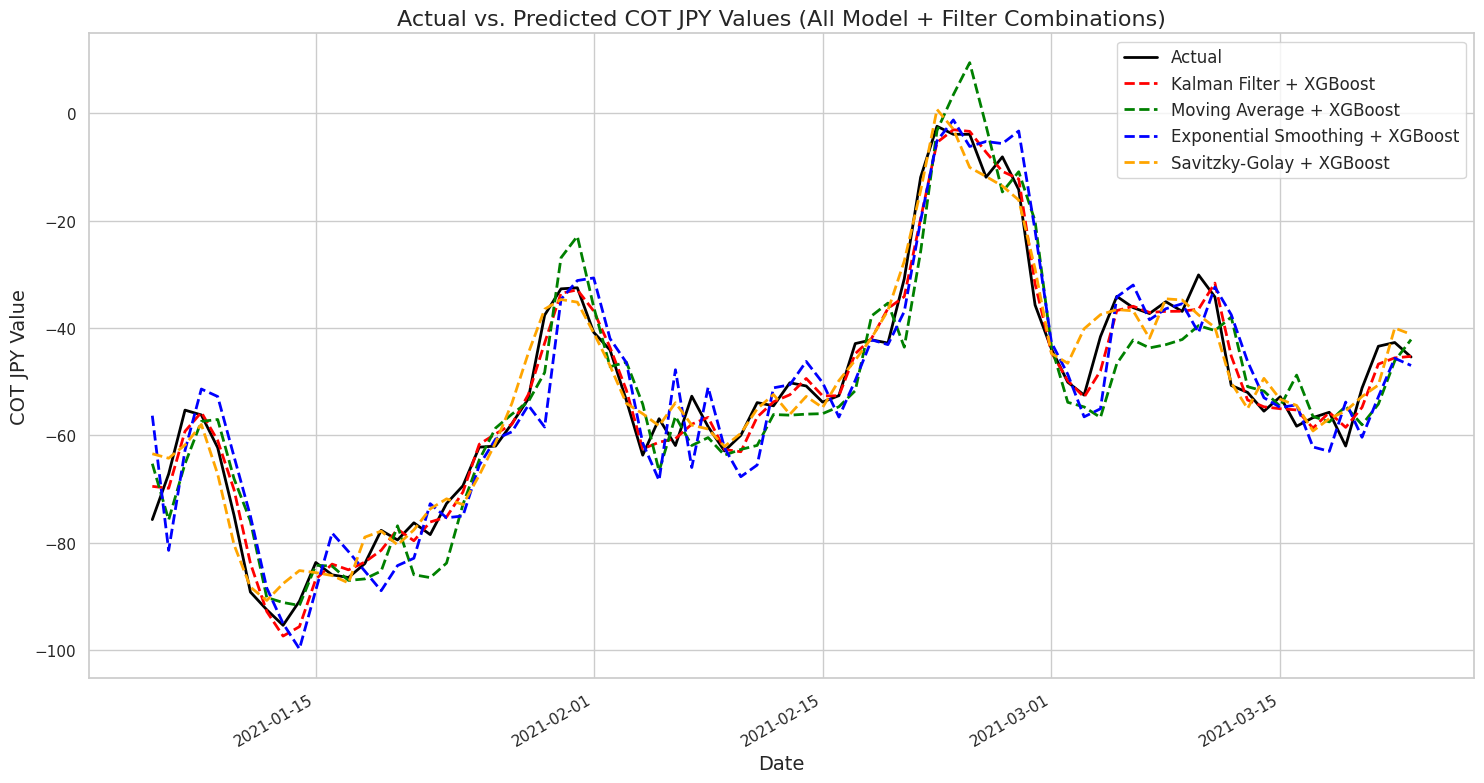

In [93]:
# Actual vs. predicted for all models
plot_actual_vs_predicted(
    dates_test=dates_test,
    y_test=y_test_original,
    predictions_dict=predictions_results,
    title='Actual vs. Predicted COT JPY Values (All Model + Filter Combinations)'
)

In [94]:
def plot_metrics_comparison(metrics_dict, title='Model + Filter Performance Comparison'):
    """
    Plots a bar chart comparing MSE, RMSE, and MAE across different model+filter combinations.

    Parameters:
    - metrics_dict: dict, keys are model+filter names and values are metrics dictionaries.
    - title: str, title of the plot.

    Returns:
    - None
    """
    # Convert metrics_dict to DataFrame
    metrics_df = pd.DataFrame(metrics_dict).T  # Transpose for easier plotting
    metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model_Filter'})

    # Melt the DataFrame for seaborn
    metrics_melted = metrics_df.melt(id_vars='Model_Filter', var_name='Metric', value_name='Value')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Metric', y='Value', hue='Model_Filter', data=metrics_melted)
    plt.title(title, fontsize=16)
    plt.xlabel('Evaluation Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(title='Model + Filter', fontsize=12)
    plt.tight_layout()
    plt.show()

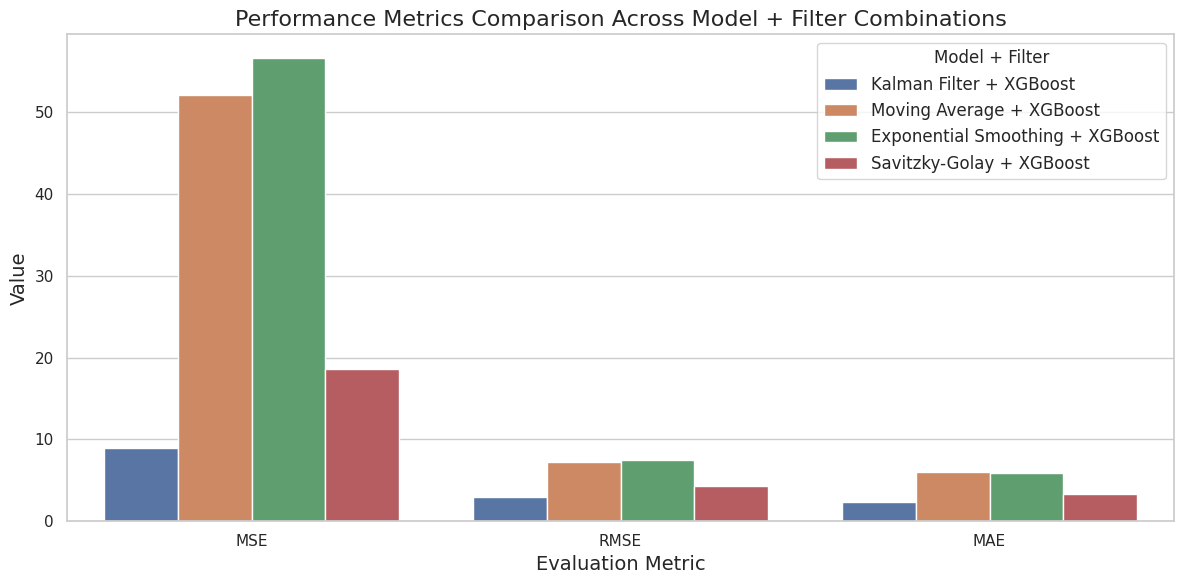

In [95]:
# Comparative visualization of metrics
plot_metrics_comparison(
    metrics_dict=metrics_results,
    title='Performance Metrics Comparison Across Model + Filter Combinations'
)